# Testing Date Rebase


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr

import dataset
import tqdm
import logging
logging.basicConfig(level=logging.INFO)

netcdf_index loaded.


## First, here is something which works.

Load a dataset and plot a variable:

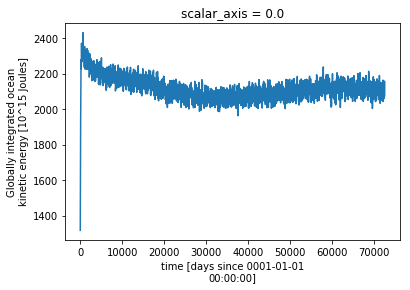

In [2]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS75/output*/ocean/ocean_scalar.nc', 
                        decode_times=False)
ds['ke_tot'].plot()

Now, rebase to 1800 with auto offset:

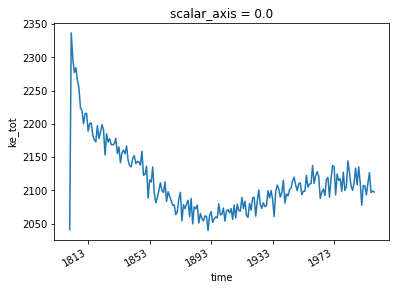

In [3]:
target_units = 'days since 1800-01-01'
ds1 = cc.rebase_dataset(ds.load(), target_units, offset='auto')
decoded_time = xr.conventions.times.decode_cf_datetime(ds1.time, target_units)
ds1.coords['time'] = ('time', decoded_time,
                      {'long_name' : 'time', 'decoded_using' : target_units }
                     )
annual_average = ds1.resample(time='A').mean()
annual_average['ke_tot'].plot()

## Ways it can fail

### 1. Providing a list of variables, instead of loading the whole dataset
This seems to be important, as it's how get_nc_variable loads the dataset -- fixed, thanks Aidan!!

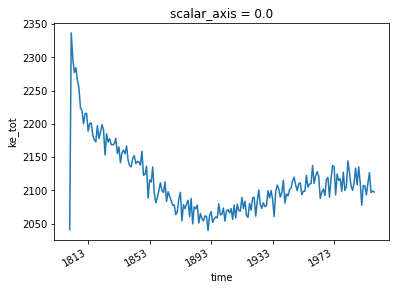

In [4]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS75/output*/ocean/ocean_scalar.nc', 
                        decode_times=False)[['ke_tot','pe_tot']]
target_units = 'days since 1800-01-01'
ds1 = cc.rebase_dataset(ds.load(), target_units, offset='auto')
decoded_time = xr.conventions.times.decode_cf_datetime(ds1.time, target_units)
ds1.coords['time'] = ('time', decoded_time,
                      {'long_name' : 'time', 'decoded_using' : target_units }
                     )
annual_average = ds1.resample(time='A').mean()
annual_average['ke_tot'].plot()

### 2. It can't seem to work on a dask dataset 
To get it to work, I had to load the whole dataset into memory. This is OK for a scalar, but will create problems with larger datasets. -- FIXED, thanks Aidan.

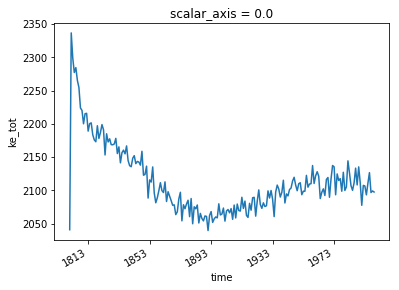

In [5]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS75/output*/ocean/ocean_scalar.nc', 
                        decode_times=False)
target_units = 'days since 1800-01-01'
ds1 = cc.rebase_dataset(ds, target_units, offset='auto')
decoded_time = xr.conventions.times.decode_cf_datetime(ds1.time, target_units)
ds1.coords['time'] = ('time', decoded_time,
                      {'long_name' : 'time', 'decoded_using' : target_units }
                     )
annual_average = ds1.resample(time='A').mean()
annual_average['ke_tot'].plot()

### 3. How should auto offset work?
It seems auto offset should at least check that the new dates will be OK ... for example, if I use an auto offset with the latest ACCESS-OM2 then I get an out of range data error as per below.


In [6]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS50/output*/ocean/ocean_scalar.nc', 
                        decode_times=False)
target_units = 'days since 1800-01-01'
ds1 = cc.rebase_dataset(ds, target_units, offset=None)
decoded_time = xr.conventions.times.decode_cf_datetime(ds1.time, target_units)
ds1.time

<xarray.DataArray 'time' (time: 1812)>
array([36515.5, 36545. , 36574.5, ..., 91538.5, 91569. , 91599.5])
Coordinates:
  * time     (time) float64 3.652e+04 3.654e+04 3.657e+04 3.660e+04 ...
Attributes:
    long_name:       time
    units:           days since 1800-01-01
    cartesian_axis:  T
    calendar_type:   NOLEAP
    calendar:        NOLEAP
    bounds:          time_bounds
    _rebased_units:  days since 0001-01-01 00:00:00

The alternative strategy is for me to just know that I have to delineate the offset I want for each experiment ... maybe this is best, but it will need to be an argument in get_nc_variable. That is, I will need something like:

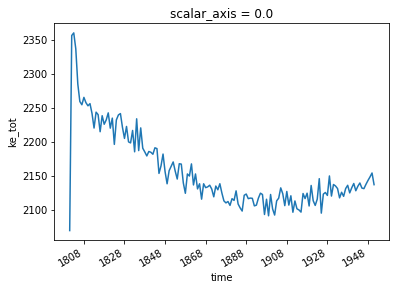

In [7]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_KDS50/output*/ocean/ocean_scalar.nc', 
                        decode_times=False)
target_units = 'days since 1800-01-01'
ds1 = cc.rebase_dataset(ds, target_units, offset=-100*365)
decoded_time = xr.conventions.times.decode_cf_datetime(ds1.time, target_units)
ds1.coords['time'] = ('time', decoded_time,
                      {'long_name' : 'time', 'decoded_using' : target_units }
                     )
annual_average = ds1.resample(time='A').mean()
annual_average['ke_tot'].plot()

### 4. One thing I would like to do ...
... is to be able to write a function which handles the dates so as to cope with runs that have different timed starts.

Here is a function which deals with this, by user-specified offsets. 

In [9]:
cosima_cookbook_dir = '/g/data3/hh5/tmp/cosima/cosima-cookbook'
database_file = '{}/cosima-cookbook.db'.format(cosima_cookbook_dir)
database_url = 'sqlite:///{}'.format(database_file)
def get_nc_var_test(expt, ncfile,
                    variable, chunks={}, n=None,
                    op=None, 
                    time_units="days since 1900-01-01",
                    use_bag = False,
                    offset=None):

    if '/' in expt:
        configuration, experiment = expt.split('/')
    else:
        experiment = expt

    if not isinstance(variable, list):
        variables = [variable]
        return_dataarray = True
    else:
        variables = variable
        return_dataarray = False

    db = dataset.connect(database_url)

    var_list = ",".join(['"{}"'.format(v) for v in variables])

    sql = " ".join(['SELECT DISTINCT ncfile, dimensions, chunking ',
                    'FROM ncfiles',
                    f'WHERE experiment = "{experiment}"',
                    'AND (',
                    f'basename_pattern = "{ncfile}"',
                    f'OR basename GLOB "{ncfile}"',
                    ')',
                    f'AND variable in ({var_list})',
                    'ORDER BY ncfile'])

    logging.debug(sql)

    res = db.query(sql)
    rows = list(res)

    ncfiles = [row['ncfile'] for row in rows]
    
    #res.close()
    
    if len(ncfiles) == 0:
        raise ValueError("No variable {} found for {} in {}".format(variable, expt, ncfile))

    #print('Found {} ncfiles'.format(len(ncfiles)))

    dimensions = eval(rows[0]['dimensions'])
    chunking = eval(rows[0]['chunking'])

    #print ('chunking info', dimensions, chunking)
    if chunking is not None:
        default_chunks = dict(zip(dimensions, chunking))
    else:
        default_chunks = {}

    if chunks is not None:
        default_chunks.update(chunks)
        chunks = default_chunks

    if n is not None:
        #print('using last {} ncfiles only'.format(n))
        if n < 0:
            ncfiles = ncfiles[n:]
        else:
            ncfiles = ncfiles[:n]

    if op is None:
        op = lambda x: x


    #print ('Opening {} ncfiles...'.format(len(ncfiles)))
    logging.debug(f'Opening {len(ncfiles)} ncfiles...')

    if use_bag:
        bag = dask.bag.from_sequence(ncfiles)
        
        load_variable = lambda ncfile: xr.open_dataset(ncfile, 
                           chunks=chunks, 
                           decode_times=False)[variables]
        #bag = bag.map(load_variable, chunks, time_units, variables)
        bag = bag.map(load_variable)
        
        dataarrays = bag.compute()
    else:
        dataarrays = []
        #for ncfile in tqdm.tqdm_notebook(ncfiles,
        #    desc='get_nc_variable:', leave=False):
        #print(ncfiles)
        for ncfile in ncfiles:
            #print(ncfile)
            dataarray = xr.open_dataset(ncfile, chunks=chunks, decode_times=False)[variables]

            #dataarray = op(dataarray)

            dataarrays.append(dataarray)

    #print ('Building dataarray.')

    dataarray = xr.concat(dataarrays,
                          dim='time', coords='all', )

    
    if 'time' in dataarray.coords:
        if time_units is None:
            time_units = dataarray.time.units
        if offset is not None:
            dataarray = cc.rebase_dataset(dataarray, time_units, offset=offset)
        try:
            decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        except:  # for compatibility with older xarray (pre-0.10.2 ?)
            decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name' : 'time', 'decoded_using' : time_units }
                                   )

    #print ('Dataarray constructed.')

    if return_dataarray:
        return dataarray[variable]
    else:
        return dataarray

In [ ]:
variable = 'temp_global_ave'
### 1 deg
expt='1deg_jra55v13_iaf_spinup1_A'
darray = cc.get_nc_variable(expt,'ocean_scalar.nc',variable,
                         time_units='days since 1718-01-01',offset = -87658)
darray.plot(label=expt)
annual_average = darray.resample(time='A').mean()
annual_average.plot(label='annual average')

### 025deg IAF
expt='025deg_jra55v13_iaf'
darray = cc.get_nc_variable(expt,'ocean_scalar.nc',variable,
                         time_units='days since 1718-01-01',offset = -87658)
darray.plot(label=expt)
annual_average = darray.resample(time='A').mean()
annual_average.plot(label='annual average')

### 025deg RYF
expt='025deg_jra55v13_ryf8485_KDS50'
darray = cc.get_nc_variable(expt,'ocean_scalar.nc',variable,n=20,
                         time_units=None,offset = None)
darray.plot(label=expt)
annual_average = darray.resample(time='A').mean()
annual_average.plot(label='annual average')

### 01deg RYF
expt='01deg_jra55v13_ryf8485_spinup6'
darray = cc.get_nc_variable(expt,'ocean_scalar.nc',variable,n=410,
                         time_units='days since 1900-01-01',offset = None)
darray.plot(label=expt)
annual_average = darray.resample(time='A').mean()
annual_average.plot(label='annual average')

print(darray.time)
plt.gca().autoscale()
plt.legend()
print(darray.time[-1])

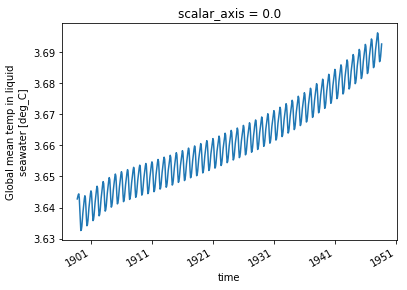

In [19]:
cc.get_nc_variable('025deg_jra55v13_ryf8485_KDS50', 'ocean_scalar.nc',
                   'temp_global_ave',n=25,time_units='days since 1900-01-01').plot()

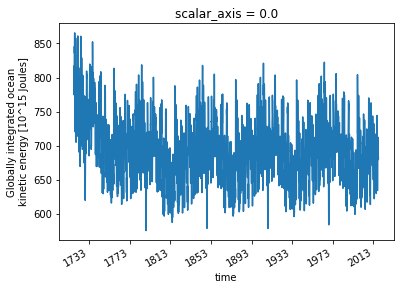

In [7]:
darray['ke_tot'].plot()


In [3]:
darray

<xarray.DataArray 'temp_global_ave' (time: 480, scalar_axis: 1)>
dask.array<shape=(480, 1), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 3797-10-12T12:00:00 3797-11-11 ...
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

<xarray.DataArray 'time' (time: 795)>
array(['1900-01-01T12:00:00.000000000', '1900-01-02T12:00:00.000000000',
       '1900-01-03T12:00:00.000000000', ..., '1936-08-07T12:00:00.000000000',
       '1936-09-07T00:00:00.000000000', '1936-10-07T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T12:00:00 1900-01-02T12:00:00 ...
Attributes:
    long_name:      time
    decoded_using:  days since 1900-01-01
<xarray.DataArray 'time' ()>
array('1936-10-07T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1936-10-07T12:00:00
Attributes:
    long_name:      time
    decoded_using:  days since 1900-01-01


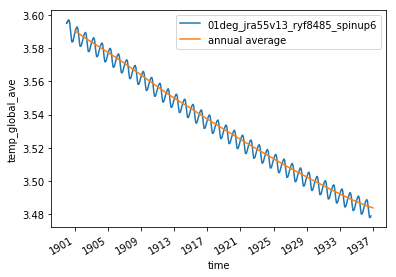

In [4]:
variable = 'temp_global_ave'


### 01deg RYF
expt='01deg_jra55v13_ryf8485_spinup6'
darray = cc.get_nc_variable(expt,'ocean_scalar.nc',variable,n=410,
                         time_units='days since 1900-01-01',offset = None)
darray.plot(label=expt)
annual_average = darray.resample(time='A').mean()
annual_average.plot(label='annual average')

print(darray.time)
plt.legend()
print(darray.time[-1])